In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lightweight_clustered_energy_forecasts.utils.paths import data_dir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Funciones auxiliares

In [4]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [5]:
def add_lags(df):
    target_map = df['kwh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    return df

In [6]:
def smape(y_true, y_pred):
  numerator = np.abs(y_true - y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  ratio = numerator / denominator
  return ratio.mean()


## Forcasting

In [7]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [8]:
building_11a.index.freq="15T"

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_15876\161432725.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  building_11a.index.freq="15T"


In [9]:
building_11a.head()

,kwh
timestamp,
2023-01-01 00:00:00+00:00,15.66
2023-01-01 00:15:00+00:00,15.39
2023-01-01 00:30:00+00:00,12.59
2023-01-01 00:45:00+00:00,11.26
2023-01-01 01:00:00+00:00,16.10


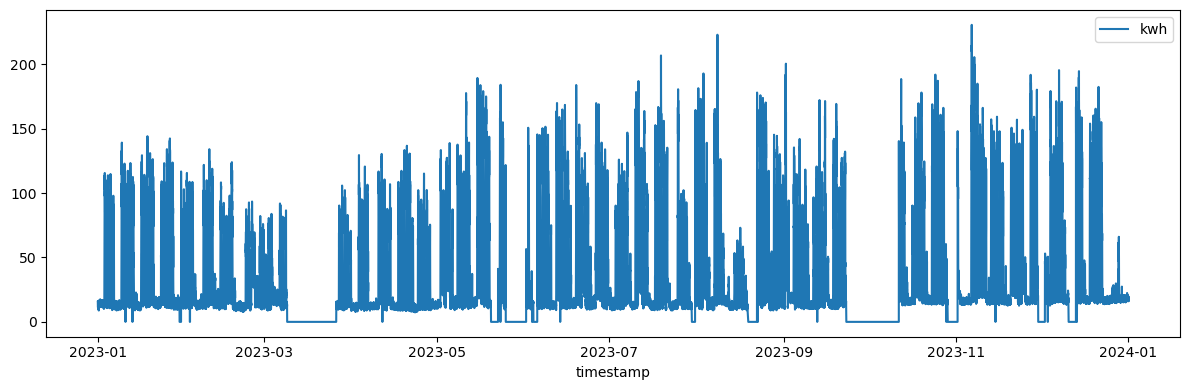

In [10]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [11]:
building_11a_hourly=building_11a.resample("h").sum()

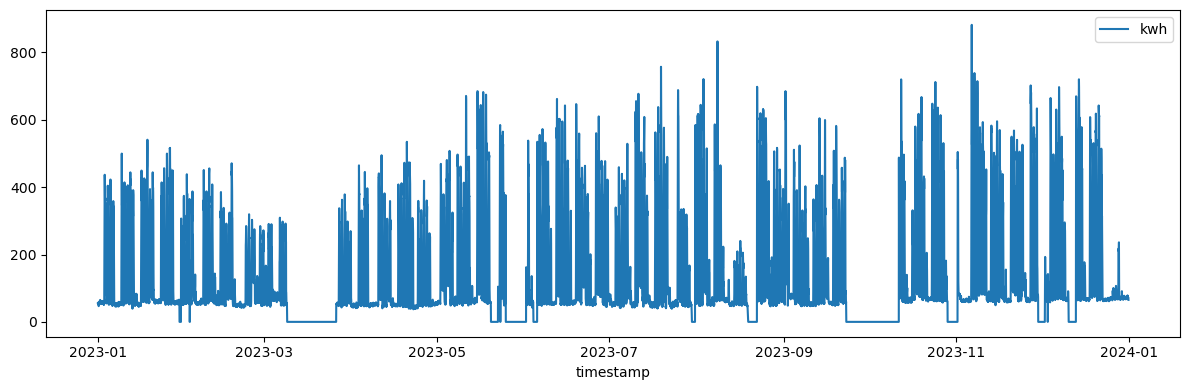

In [12]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a_hourly)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Feature extraction

In [13]:
building_11a_hourly =create_features(building_11a_hourly)
building_11a_hourly=add_lags(building_11a_hourly)


In [14]:
train = building_11a_hourly.loc[building_11a_hourly.index < '2023-12-24']
test = building_11a_hourly.loc[building_11a_hourly.index >= '2023-12-24']

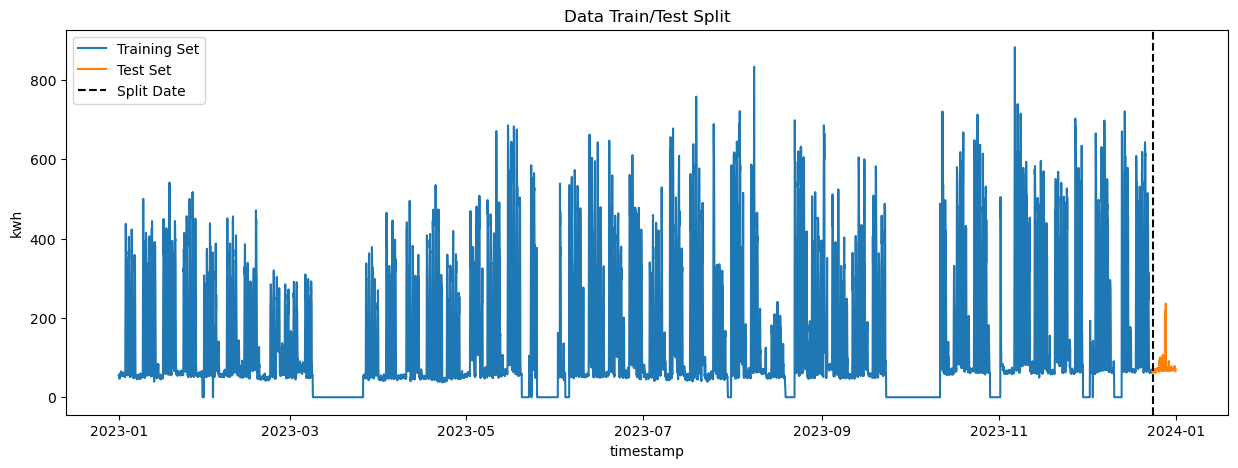

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
# Graficar las líneas para los conjuntos de entrenamiento y prueba
sns.lineplot(data=train, x=train.index, y="kwh", ax=ax, label="Training Set")
sns.lineplot(data=test, x=test.index, y="kwh", ax=ax, label="Test Set")
# Agregar una línea vertical en una fecha específica
ax.axvline(pd.to_datetime('2023-12-24'), color='black', ls='--', label='Split Date')
# Configurar el título y la leyenda
ax.set_title('Data Train/Test Split')
ax.legend()
# Mostrar el gráfico
plt.show()

In [16]:
X_train, y_train =train.drop(columns=["kwh"]), train["kwh"]
X_test, y_test = test.drop(columns=["kwh"]), test["kwh"]

In [17]:
X_test.head()

,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
timestamp,,,,,,,,,,
2023-12-24 00:00:00+00:00,0,6,4,12,358,24,51,62.97,63.46,64.70
2023-12-24 01:00:00+00:00,1,6,4,12,358,24,51,61.39,66.51,62.50
2023-12-24 02:00:00+00:00,2,6,4,12,358,24,51,63.03,65.55,65.77
2023-12-24 03:00:00+00:00,3,6,4,12,358,24,51,62.89,65.37,65.81
2023-12-24 04:00:00+00:00,4,6,4,12,358,24,51,63.77,68.65,64.47


## time series cross validation

In [18]:
from sklearn.model_selection import TimeSeriesSplit

In [19]:
#in the test size we define the horizon we want to predict if we want to predict 30 days we have to set 24 hours *30 days
#gap is the space we want to set between the train set ends and the test set starts
tss = TimeSeriesSplit(n_splits=5, test_size=24*7, gap=24)
df = building_11a_hourly.sort_index()

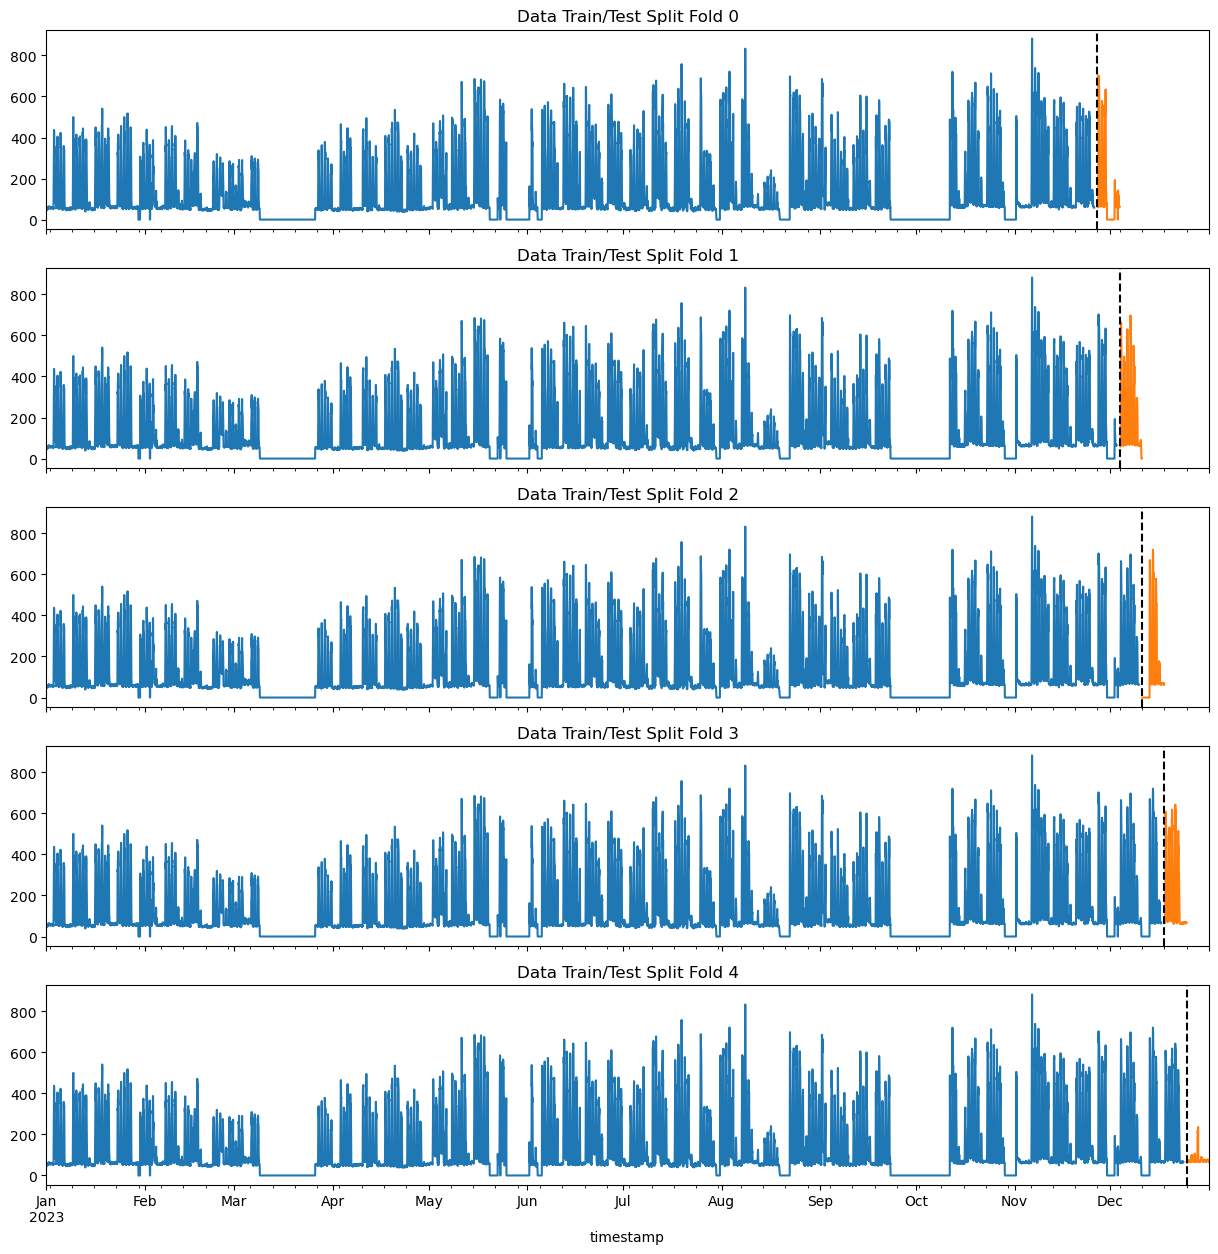

In [20]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['kwh'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['kwh'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Training

In [21]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*7, gap=12)
df = building_11a_hourly.sort_index()

fold = 0
preds = []
scores = []
scores_smape=[]
for train_idx, val_idx in tss.split(df):
    df =create_features(df)
    df=add_lags(df)

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
#    train =create_features(train)
#    train=add_lags(train)
#    test =create_features(test)
#    test=add_lags(test)
    TARGET = 'kwh'

    X_train = train.drop(columns=[TARGET])
    y_train = train[TARGET]

    X_test = test.drop(columns=[TARGET])
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,eval_metric='mae')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    smape_score=smape(y_test, y_pred)
    scores_smape.append(smape_score)

[0]	validation_0-mae:120.38916	validation_1-mae:125.52357
[100]	validation_0-mae:58.93158	validation_1-mae:94.22096
[200]	validation_0-mae:42.98682	validation_1-mae:80.04473
[300]	validation_0-mae:39.74576	validation_1-mae:77.00558
[367]	validation_0-mae:38.85995	validation_1-mae:80.01788
[0]	validation_0-mae:120.48474	validation_1-mae:186.74835
[100]	validation_0-mae:59.58498	validation_1-mae:107.91421
[200]	validation_0-mae:43.73792	validation_1-mae:95.22227
[300]	validation_0-mae:40.40269	validation_1-mae:95.99021
[301]	validation_0-mae:40.39073	validation_1-mae:96.10769
[0]	validation_0-mae:121.88045	validation_1-mae:120.10884
[100]	validation_0-mae:60.40232	validation_1-mae:87.27374
[200]	validation_0-mae:44.20175	validation_1-mae:83.57386
[218]	validation_0-mae:43.16982	validation_1-mae:83.56509
[0]	validation_0-mae:121.80901	validation_1-mae:180.58194
[100]	validation_0-mae:61.14270	validation_1-mae:88.52572
[200]	validation_0-mae:45.35687	validation_1-mae:56.86538
[300]	validat

In [22]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'smape across folds {np.mean(scores_smape):0.4f}')

print(f'Fold scores:{scores}')

Score across folds 115.1170
smape across folds 0.6324
Fold scores:[np.float64(126.73725341756796), np.float64(162.391519576884), np.float64(142.43320890562916), np.float64(102.67338034008715), np.float64(41.34943020501399)]


In [23]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 300],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Usamos RMSE como métrica
    cv=3
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, así que lo multiplicamos por -1)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Mostrar los resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])



Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Mejor puntuación de validación (RMSE): 91.35629507527801
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 100      -102.185382   
1                 3                 0.01                 150       -94.967236   
2                 3                 0.01                 300       -91.356295   
3                 5                 0.01                 100      -105.370141   
4                 5                 0.01                 150      -100.365597   
5                 5                 0.01                 300       -97.861716   
6                 7                 0.01                 100      -118.531115   
7                 7                 0.01                 150      -114.259089   
8                 7                 0.01                 300      -112.069788   
9                 3                 0.05

## Predicting the future

In [24]:
# Entrenar el modelo
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=300,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)


In [34]:
from sklearn import set_config
set_config(display="text")
import time

In [26]:
reg.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
start_time = time.time()
predictions = reg.predict(X_test)

# Calcular el tiempo de ejecución
execution_time = time.time() - start_time

# Imprimir el tiempo de ejecución
print(f"Tiempo de ejecución: {execution_time} segundos")

Tiempo de ejecución: 0.021628141403198242 segundos


In [28]:
smape_score=smape(y_test, predictions)
smape_score

np.float64(0.3460606956527745)

In [29]:
# Calcular métricas de error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
smape_score=smape(y_test, predictions)


print(f"RMSE: {rmse:.2f}")
print(f"sMAPE: {smape_score:.2f}")

RMSE: 87.27
sMAPE: 0.35


In [30]:
test_df = test.reset_index()
test_df['predictions'] = pd.Series(predictions)

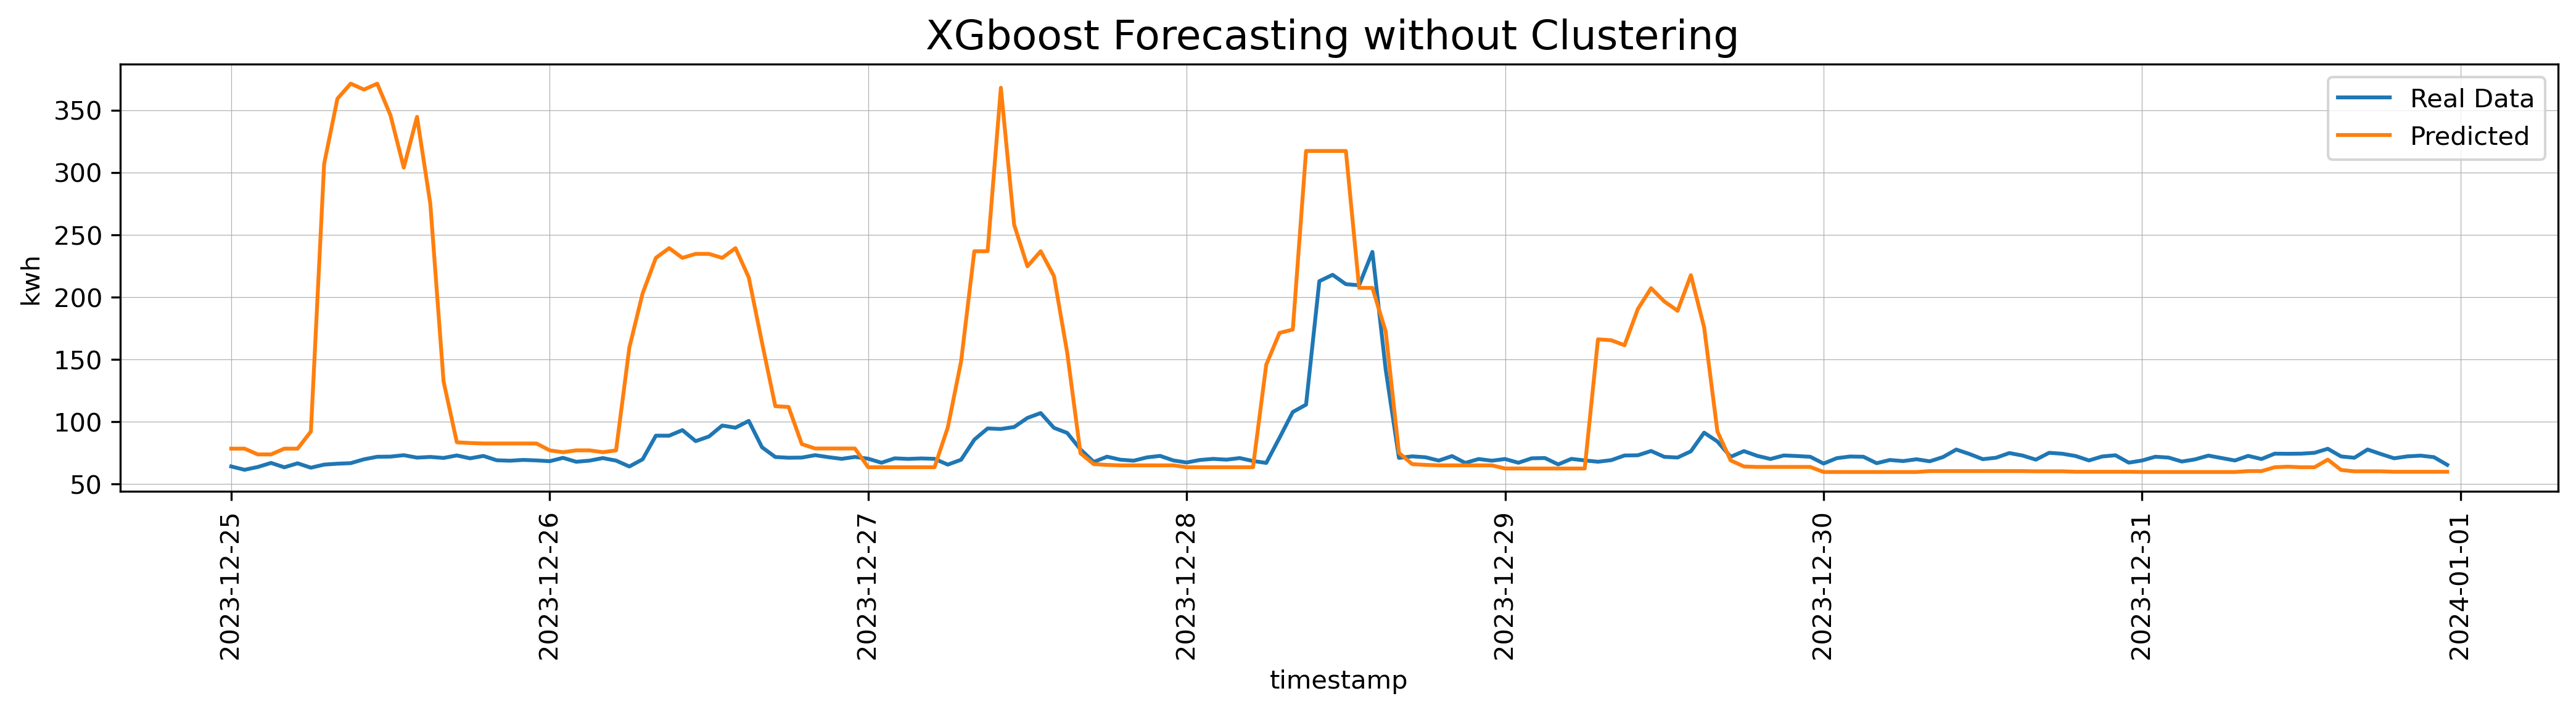

In [33]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_df, x='timestamp', y='kwh', label='Real Data')
sns.lineplot(data=test_df, x='timestamp',  y='predictions', label='Predicted')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# Agregar título
plt.title('XGboost Forecasting without Clustering ', fontsize=16)
plt.legend()
plt.show()